In [194]:
import zombie_imp
import csv
import serial
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import pywt
import numpy as np
from scipy import stats
import statistics
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
from scipy.fft import fft
from scipy.fftpack import dct

In [52]:
class RingBuffer:
    def __init__(self, size):
        self.size = size
        self.data = [None] * size
        self.head = 0
        self.tail = 0
        self.count = 0

    def append(self, item):
        if self.count < self.size:
            self.data[self.tail] = item
            self.tail = (self.tail + 1) % self.size
            self.count += 1
        else:
            # If the buffer is full, overwrite the oldest data
            self.data[self.head] = item
            self.head = (self.head + 1) % self.size
            self.tail = (self.tail + 1) % self.size

    def get(self):
        return [self.data[(self.head + i) % self.size] for i in range(self.count)]
    
    def clear(self):
        self.data = [None] * self.size
        self.head = 0
        self.tail = 0
        self.count = 0

    def __len__(self):
        return self.count

## Read the data from serial port

In [150]:
# Initialize the Serial port
ser = serial.Serial('COM3', 115200)  # Change the port and baud rate according to transmitter

#for three cells
# create the CSV file
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Cell 1', 'Cell 2', 'Cell 3'])  

#     # read the data from port and store in CSV file
#     try:
#         while True:
#             data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
#             if data:
#                 values = data.split(' ')  # split with space
#                 if len(values) == 3:  # make sure there are three values
#                     writer.writerow([int(val) for val in values])  # store the data
#     except KeyboardInterrupt:  # stop iteration by Ctrl+C
#         pass

#for two cells
with open('sensor_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Gesture', 'Cell 1', 'Cell 2'])  

    # read the data from port and store in CSV file
    try:
        while True:
            data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
            if data:
                values = data.split(' ')  # split with space
                if len(values) == 2:  # make sure there are three values
                    writer.writerow(['vertical', int(values[0]), int(values[1])])  # store the data, change the gesture accordingly
    except KeyboardInterrupt:  # stop iteration by Ctrl+C
        pass
    finally:
        ser.close()
        
# #for one cell
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Sensor Value']) 

#     try:
#         while True:
#             data = ser.readline().decode('utf-8').strip()  
#             if data:
#                 writer.writerow([int(data)])  
#     except KeyboardInterrupt:  
#         pass
#     finally:
#         ser.close()

## Load the CSV files for different gestures

In [151]:
# read the csv file
df_1 = pd.read_csv('final_dataset/flat.csv')
df_2 = pd.read_csv('final_dataset/vertical.csv')

# get the data of each solar cell
cell_1_label = df_1['Gesture']
solar_cell_1_flat = df_1['Cell 1']
solar_cell_2_flat = df_1['Cell 2']
cell_2_label = df_1['Gesture']
solar_cell_1_vertical = df_2['Cell 1']
solar_cell_2_vertical = df_2['Cell 2']

# apply DWT for the current value of each solar cell
coeffs_1_flat = pywt.wavedec(solar_cell_1_flat, 'haar', level=5) #coeffs_1[0] contains the first-level approximation coefficient of solar_cell_1, coeffs_1[1] contains the first-level detail coefficient of solar_cell_1
coeffs_2_flat = pywt.wavedec(solar_cell_2_flat, 'haar', level=5)
coeffs_1_vertical = pywt.wavedec(solar_cell_1_vertical, 'haar', level=5)
coeffs_2_vertical = pywt.wavedec(solar_cell_2_vertical, 'haar', level=5)

## Use DWT to denoise

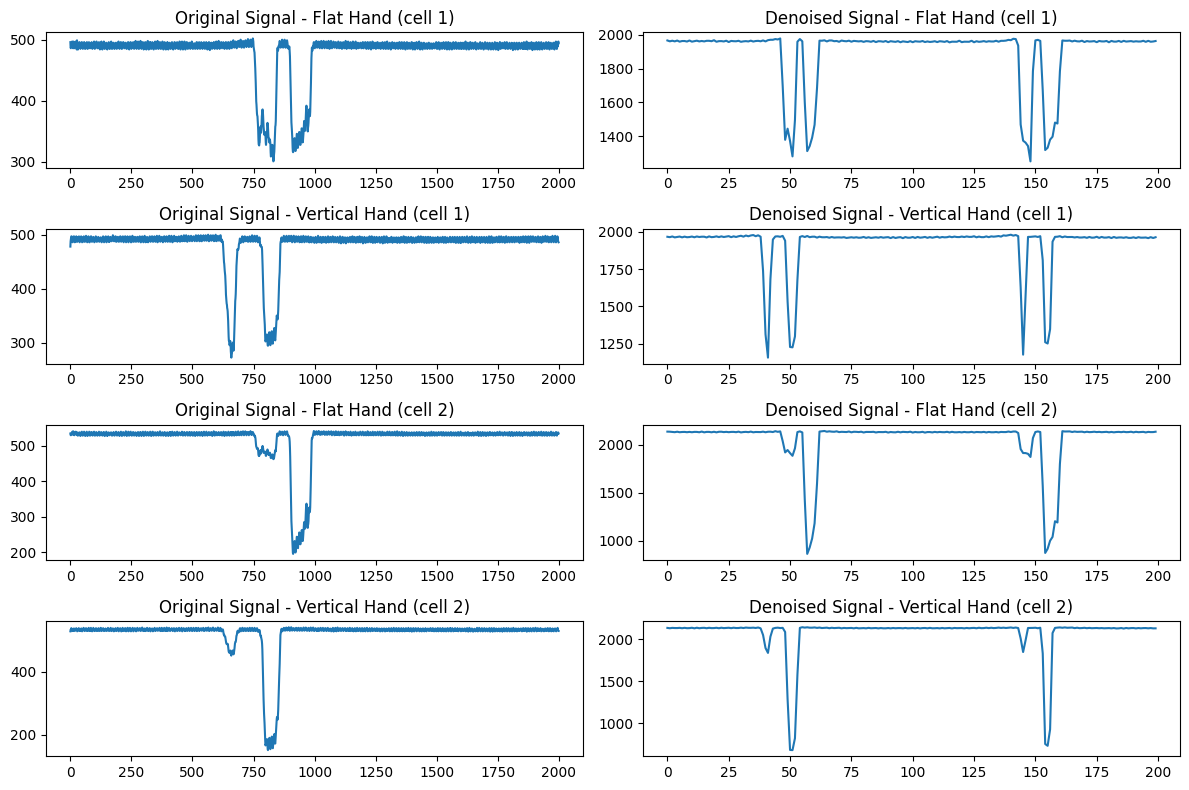

In [154]:
# should be changed based on reality
threshold = 0.5

# For cell 1
approx_coeff_1_flat = coeffs_1_flat[0]
detail_coeff_1_flat = coeffs_1_flat[1]
approx_coeff_1_vertical = coeffs_1_vertical[0]
detail_coeff_1_vertical = coeffs_1_vertical[1]

## Apply a threshold on the detail coefficient on signals of cell 1
detail_coeff_thresh_1_flat = pywt.threshold(detail_coeff_1_flat, threshold, mode='soft')
detail_coeff_thresh_1_vertical = pywt.threshold(detail_coeff_1_vertical, threshold, mode='soft')

## Reconstruct the signal for different gestures of cell 1
coeffs_denoised_1_flat = [approx_coeff_1_flat, detail_coeff_thresh_1_flat]
solar_cell_denoised_1_flat = pywt.waverec(coeffs_denoised_1_flat, 'haar')
coeffs_denoised_1_vertical = [approx_coeff_1_vertical, detail_coeff_thresh_1_vertical]
solar_cell_denoised_1_vertical = pywt.waverec(coeffs_denoised_1_vertical, 'haar')

# For cell 2
approx_coeff_2_flat = coeffs_2_flat[0]
detail_coeff_2_flat = coeffs_2_flat[1]
approx_coeff_2_vertical = coeffs_2_vertical[0]
detail_coeff_2_vertical = coeffs_2_vertical[1]

## Apply a threshold on the detail coefficient of signals of cell 2
detail_coeff_thresh_2_flat = pywt.threshold(detail_coeff_2_flat, threshold, mode='soft')
detail_coeff_thresh_2_vertical = pywt.threshold(detail_coeff_2_vertical, threshold, mode='soft')

## Reconstruct the signal for different gestures of cell 2
coeffs_denoised_2_flat = [approx_coeff_2_flat, detail_coeff_thresh_2_flat]
solar_cell_denoised_2_flat = pywt.waverec(coeffs_denoised_2_flat, 'haar')
coeffs_denoised_2_vertical = [approx_coeff_2_vertical, detail_coeff_thresh_2_vertical]
solar_cell_denoised_2_vertical = pywt.waverec(coeffs_denoised_2_vertical, 'haar')


# plot the comparison of single before and after denoising
plt.figure(figsize=(12, 8))

plt.subplot(4, 2, 1)
plt.plot(solar_cell_1_flat[0:2000])
plt.title('Original Signal - Flat Hand (cell 1)')

plt.subplot(4, 2, 2)
plt.plot(solar_cell_denoised_1_flat[0:200])
plt.title('Denoised Signal - Flat Hand (cell 1)')

plt.subplot(4, 2, 3)
plt.plot(solar_cell_1_vertical[0:2000])
plt.title('Original Signal - Vertical Hand (cell 1)')

plt.subplot(4, 2, 4)
plt.plot(solar_cell_denoised_1_vertical[0:200])
plt.title('Denoised Signal - Vertical Hand (cell 1)')

plt.subplot(4, 2, 5)
plt.plot(solar_cell_2_flat[0:2000])
plt.title('Original Signal - Flat Hand (cell 2)')

plt.subplot(4, 2, 6)
plt.plot(solar_cell_denoised_2_flat[0:200])
plt.title('Denoised Signal - Flat Hand (cell 2)')

plt.subplot(4, 2, 7)
plt.plot(solar_cell_2_vertical[0:2000])
plt.title('Original Signal - Vertical Hand (cell 2)')

plt.subplot(4, 2, 8)
plt.plot(solar_cell_denoised_2_vertical[0:200])
plt.title('Denoised Signal - Vertical Hand (cell 2)')


plt.tight_layout()
plt.show()

## Segmentation of each signal

In [158]:
class CellProcessor:
    def __init__(self):
        self.last5s = RingBuffer(2500)
        self.historyBuffer = RingBuffer(100)
        self.sliceArray = []
        self.busyReading = False
        self.avgMean = 0
        self.historyMean = 100000
        self.samplingStep = 0
        self.nrOfSlices = 0
        self.slice_arr = [] # all the segmentation slices is stored in this list for one signal

    def process_signal(self, signal):
        for sigVal in signal:
            if (not self.busyReading):
                self.last5s.append(sigVal)
                self.avgMean = np.mean(self.last5s.get())
                self.historyBuffer.append(sigVal)
                self.historyMean = np.mean(self.historyBuffer.get())

            if self.historyMean < 0.95 * self.avgMean and self.samplingStep < 412:
                self.busyReading = True
                if not self.sliceArray:
                    self.sliceArray = self.historyBuffer.get()
                else:
                    self.sliceArray.append(sigVal)
                self.samplingStep += 1
            elif self.busyReading:
                # plt.plot(self.sliceArray)
                # plt.show()
                self.slice_arr.append(self.sliceArray)
                print("Finished 1 slice")
                self.samplingStep = 0
                self.busyReading = False
                self.historyMean = 1000000
                self.historyBuffer.clear()
                self.sliceArray = []
                self.nrOfSlices += 1

# Create the instance
processor_1_flat = CellProcessor()
processor_1_vertical = CellProcessor()
processor_2_flat = CellProcessor()
processor_2_vertical = CellProcessor()

# process the signal
processor_1_flat.process_signal(solar_cell_1_flat)
processor_1_vertical.process_signal(solar_cell_1_vertical)
processor_2_flat.process_signal(solar_cell_2_flat)
processor_2_vertical.process_signal(solar_cell_2_vertical)



Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 slice
Finished 1 sli

## Get the features of different gestures

In [196]:
def interpolate_signal(signal, target_length=512):
    original_time = np.linspace(0, 1, len(signal))
    interpolator = interp1d(original_time, signal, kind='linear')
    upscaled_time = np.linspace(0, 1, target_length)
    return interpolator(upscaled_time)

def denoise_slice(slice):
    # should be changed based on reality
    threshold = 0.4
    # denoise the slice first, and then interpolation, and then calculate the detail coefficients. use these coefficients to calculate min, max mean
    coeffs = pywt.wavedec(slice, 'haar', level=5)
    approx_coeffs = coeffs[0]
    detail_coeffs = coeffs[1]
    
    # Apply a threshold on the detail coefficient on signals of cell 1
    detail_coeff_thresh = pywt.threshold(detail_coeffs, threshold, mode='soft')
    
    # Reconstruct the signal for different gestures of cell 1
    coeffs_denoised = [approx_coeffs, detail_coeff_thresh]
    slice_denoised = pywt.waverec(coeffs_denoised, 'haar')
    return slice_denoised

# denoise the slice first, and then interpolation, and then calculate the detail coefficients. use these coefficients to calculate min, max mean
def extract_features_from_slice(slice):    
    coeffs = pywt.wavedec(slice, 'haar', level=5)
    std_dev = statistics.stdev(coeffs[1])
    mean_val = np.mean(coeffs[1])
    min_val = np.min(coeffs[1])
    max_val = np.max(coeffs[1])
    difference = max_val - min_val
    return std_dev, mean_val, min_val, max_val, difference

# denoise the slice firstly, and then calculate statistical values directly. Z-score first gives a better performance!!!!!!!!!
def extract_features_from_slice_denoised(slice):
    # Extract the features
    # slice = stats.zscore(slice)
    std_dev = statistics.stdev(slice)
    mean_val = np.mean(slice)
    min_val = np.min(slice)
    max_val = np.max(slice)
    difference = max_val - min_val
    return std_dev, mean_val, min_val, max_val, difference
    
def process_solar_cell(sliceArray):
    features = {
        # the features below are calculated with DWT coefficients
        'std_dev': [],
        'mean_val': [],
        'min_val': [],
        'max_val': [],
        'difference': [],
        # the features below are calculated with denoised slices
        'std_dev_signal': [],
        'mean_val_signal': [],
        'min_val_signal': [],
        'max_val_signal': [],
        'difference_signal': []
    }

    for slice in sliceArray:
        denoised_slice = denoise_slice(slice)
        interpolated_slice = interpolate_signal(denoised_slice)
        std_dev, mean_val, min_val, max_val, difference = extract_features_from_slice(interpolated_slice)
        std_dev_signal, mean_val_signal, min_val_signal, max_val_signal, difference_signal = extract_features_from_slice_denoised(denoised_slice)

        features['std_dev'].append(std_dev)
        features['mean_val'].append(mean_val)
        features['min_val'].append(min_val)
        features['max_val'].append(max_val)
        features['difference'].append(difference)

        features['std_dev_signal'].append(std_dev_signal)
        features['mean_val_signal'].append(mean_val_signal)
        features['min_val_signal'].append(min_val_signal)
        features['max_val_signal'].append(max_val_signal)
        features['difference_signal'].append(difference_signal)

    return features

# Process of cell 1
features_solar_1_flat = process_solar_cell(processor_1_flat.slice_arr)
features_solar_1_vertical = process_solar_cell(processor_1_vertical.slice_arr)

# Process of cell 2
features_solar_2_flat = process_solar_cell(processor_2_flat.slice_arr)
features_solar_2_vertical = process_solar_cell(processor_2_vertical.slice_arr)

# Output
# print("Flat Hand cell 1")
# print(features_solar_1_flat)
# print("Vertical Hand cell 1")
# print(features_solar_1_vertical)
# print("Flat Hand cell 2")
# print(features_solar_2_flat)
# print("Vertical Hand cell 2")
# print(features_solar_2_vertical)


## Train the KNN model of different cells

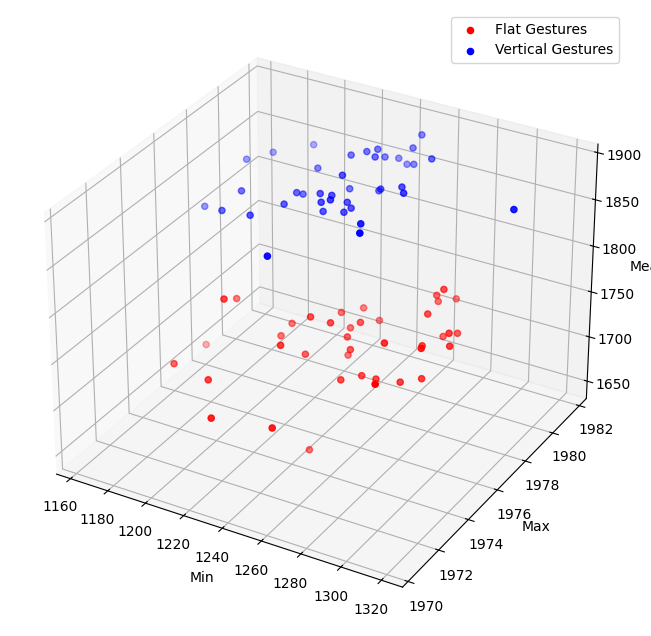

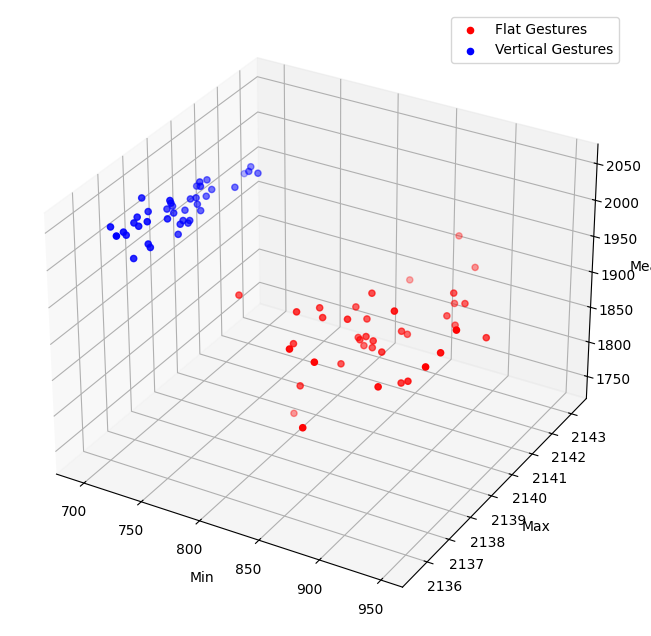

In [197]:
# Train the KNN model for cell 1
X_train_flat_1 = np.column_stack((features_solar_1_flat['min_val_signal'],features_solar_1_flat['max_val_signal'], features_solar_1_flat['mean_val_signal']))
X_train_vertical_1 = np.column_stack((features_solar_1_vertical['min_val_signal'], features_solar_1_vertical['max_val_signal'], features_solar_1_vertical['mean_val_signal']))
# X_train_flat_1 = np.column_stack((features_solar_1_flat['min_val'],features_solar_1_flat['max_val'], features_solar_1_flat['mean_val']))
# X_train_vertical_1 = np.column_stack((features_solar_1_vertical['min_val'], features_solar_1_vertical['max_val'], features_solar_1_vertical['mean_val']))
X_train_1 = np.concatenate((X_train_flat_1, X_train_vertical_1), axis=0)

Y_train_1 = ['flat'] * 40 + ['vertical']*40
knn_model_1 = KNeighborsClassifier(n_neighbors=3)  
knn_model_1.fit(X_train_1, Y_train_1)  # train the model

fig_1 = plt.figure(figsize=(10, 8))
ax_1 = fig_1.add_subplot(projection='3d')

# Feature Extraction of cell 1
min_1_flat, std_1_flat, mean_1_flat = X_train_flat_1[:, 0], X_train_flat_1[:, 1], X_train_flat_1[:, 2]
min_1_vertical, std_1_vertical, mean_1_vertical = X_train_vertical_1[:, 0], X_train_vertical_1[:, 1], X_train_vertical_1[:, 2]

# Plot the figure for cell 1
ax_1.scatter(min_1_flat, std_1_flat, mean_1_flat, c='r', label='Flat Gestures')
ax_1.scatter(min_1_vertical, std_1_vertical, mean_1_vertical, c='b', label='Vertical Gestures')

# Add axises labels
ax_1.set_xlabel('Min')
ax_1.set_ylabel('Max')
ax_1.set_zlabel('Mean')

ax_1.legend()

plt.show()


# Train the KNN model for cell 2
X_train_flat_2 = np.column_stack((features_solar_2_flat['min_val_signal'],features_solar_2_flat['max_val_signal'], features_solar_2_flat['mean_val_signal']))
X_train_vertical_2 = np.column_stack((features_solar_2_vertical['min_val_signal'], features_solar_2_vertical['max_val_signal'], features_solar_2_vertical['mean_val_signal']))
# X_train_flat_2 = np.column_stack((features_solar_2_flat['min_val'],features_solar_2_flat['max_val'], features_solar_2_flat['mean_val']))
# X_train_vertical_2 = np.column_stack((features_solar_2_vertical['min_val'], features_solar_2_vertical['max_val'], features_solar_2_vertical['mean_val']))
X_train_2 = np.concatenate((X_train_flat_2, X_train_vertical_2), axis=0)

Y_train_2 = ['flat'] * 40 + ['vertical']*40
knn_model_2 = KNeighborsClassifier(n_neighbors=3)  
knn_model_2.fit(X_train_2, Y_train_2)  # train the model

fig_2 = plt.figure(figsize=(10, 8))
ax_2 = fig_2.add_subplot(projection='3d')

# Feature Extraction of cell 2
min_2_flat, std_2_flat, mean_2_flat = X_train_flat_2[:, 0], X_train_flat_2[:, 1], X_train_flat_2[:, 2]
min_2_vertical, std_2_vertical, mean_2_vertical = X_train_vertical_2[:, 0], X_train_vertical_2[:, 1], X_train_vertical_2[:, 2]

# Plot the figure for cell 2
ax_2.scatter(min_2_flat, std_2_flat, mean_2_flat, c='r', label='Flat Gestures')
ax_2.scatter(min_2_vertical, std_2_vertical, mean_2_vertical, c='b', label='Vertical Gestures')

# Add axises labels
ax_2.set_xlabel('Min')
ax_2.set_ylabel('Max')
ax_2.set_zlabel('Mean')

ax_2.legend()

plt.show()

## Train the KNN model with combination of different cells, time domain difference as feature to get the gesture move direction

In [205]:
def find_min_position_difference(slice_list1, slice_list2):
    min_positions_slice1 = [np.argmin(slice1) for slice1 in slice_list1]
    min_positions_slice2 = [np.argmin(slice2) for slice2 in slice_list2]
    position_differences = [pos2 - pos1 for pos1, pos2 in zip(min_positions_slice1, min_positions_slice2)]
    return position_differences

feature_flat_diff = find_min_position_difference(processor_1_flat.slice_arr, processor_2_flat.slice_arr) # the inputs here are the list of slices before denoising
feature_vertical_diff = find_min_position_difference(processor_1_vertical.slice_arr, processor_2_vertical.slice_arr)
print(feature_flat_diff)
print(feature_vertical_diff)

[42, 63, 44, 43, 54, 45, 56, 41, 52, 53, 53, 59, 61, 46, 53, 40, 43, 29, 42, 42, 45, 60, 46, 55, 46, 55, 37, 58, 54, 39, 38, 55, 58, 36, 64, 54, 63, 47, 54, 63]
[4, 8, 8, -2, 4, 8, 6, 8, 4, -1, 2, 10, 6, 6, 0, 11, 11, 8, 5, 11, 6, 9, 13, 9, 6, 16, 13, 11, 17, 13, 12, 3, 9, 6, 8, 3, -122, 9, 8, 1]


## Use FFT and DCT to get the frequency features

In [206]:
def extract_fft_feature(slice_list):
    fft_features = []
    for signal in slice_list:
        spectrum = fft(signal)
        amplitude_spectrum = np.abs(spectrum)
        fft_features.append(np.mean(amplitude_spectrum))
    return fft_features

def extract_dct_feature(slice_list):
    dct_features = []
    for signal in slice_list:
        dct_coefficients = dct(signal, type=2, norm='ortho')
        dct_features.append(np.mean(dct_coefficients))
    return dct_features

feature_fft_1_flat = extract_fft_feature(processor_1_flat.slice_arr)
feature_fft_2_flat = extract_fft_feature(processor_2_flat.slice_arr)
feature_fft_1_vertical = extract_fft_feature(processor_1_vertical.slice_arr)
feature_fft_2_vertical = extract_fft_feature(processor_2_vertical.slice_arr)

feature_dct_1_flat = extract_dct_feature(processor_1_flat.slice_arr)
feature_dct_2_flat = extract_dct_feature(processor_2_flat.slice_arr)
feature_dct_1_vertical = extract_dct_feature(processor_1_vertical.slice_arr)
feature_dct_2_vertical = extract_dct_feature(processor_2_vertical.slice_arr)

print(feature_fft_1_flat)
print(feature_fft_2_flat)
print(feature_fft_1_vertical)
print(feature_fft_2_vertical)
print(feature_dct_1_flat)
print(feature_dct_2_flat)
print(feature_dct_1_vertical)
print(feature_dct_2_vertical)

[786.3105971439302, 809.3993782802683, 805.5732666426611, 806.0582688731582, 814.3401182300296, 807.7586100280546, 806.2761976736235, 795.9508740218437, 796.4353986930251, 791.0776152914425, 779.7459620626928, 772.5483588774292, 753.4522967663102, 792.6711275933629, 775.1414762332103, 788.0464635476176, 780.0250300536622, 793.8315427789149, 781.973330801574, 786.7390880262217, 783.1225384003516, 783.1394994654681, 783.2767074140005, 778.1897104754073, 779.0772348119381, 780.7226146793687, 786.7237813940365, 773.9464629462177, 804.9516683471406, 808.0250397796195, 776.7104427223767, 819.6792384377261, 792.4834316797194, 794.8694949358788, 791.8253882564634, 786.4117646284948, 794.435946221634, 795.1062441482308, 801.6387068917335, 778.8057673339696]
[989.6354302713988, 986.6555753819993, 992.0331192872029, 996.2883719208382, 1001.2657529705646, 997.5802342748443, 990.319767501477, 994.0806051184661, 989.8816189240216, 989.7394665392488, 968.8961479530989, 962.0847816775223, 938.11348969

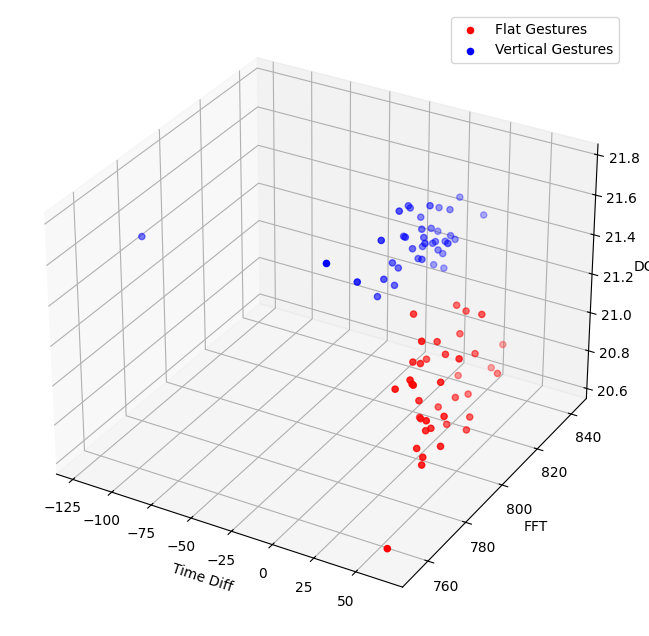

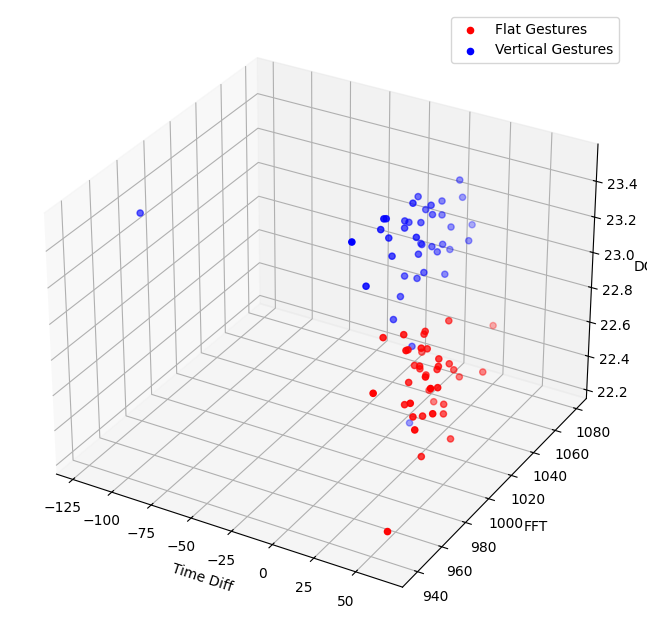

In [209]:
# Train the KNN model for cell 1
X_train_flat_1 = np.column_stack((feature_flat_diff,feature_fft_1_flat,feature_dct_1_flat))
X_train_vertical_1 = np.column_stack((feature_vertical_diff, feature_fft_1_vertical,feature_dct_1_vertical))

X_train_1 = np.concatenate((X_train_flat_1, X_train_vertical_1), axis=0)

Y_train_1 = ['flat'] * 40 + ['vertical']*40
knn_model_3 = KNeighborsClassifier(n_neighbors=3)  
knn_model_3.fit(X_train_1, Y_train_1)  # train the model

fig_1 = plt.figure(figsize=(10, 8))
ax_1 = fig_1.add_subplot(projection='3d')

# Feature Extraction of cell 1
min_1_flat, std_1_flat, mean_1_flat = X_train_flat_1[:, 0], X_train_flat_1[:, 1], X_train_flat_1[:, 2]
min_1_vertical, std_1_vertical, mean_1_vertical = X_train_vertical_1[:, 0], X_train_vertical_1[:, 1], X_train_vertical_1[:, 2]

# Plot the figure for cell 1
ax_1.scatter(min_1_flat, std_1_flat, mean_1_flat, c='r', label='Flat Gestures')
ax_1.scatter(min_1_vertical, std_1_vertical, mean_1_vertical, c='b', label='Vertical Gestures')

# Add axises labels
ax_1.set_xlabel('Time Diff')
ax_1.set_ylabel('FFT')
ax_1.set_zlabel('DCT')


ax_1.legend()

plt.show()


# Train the KNN model for cell 2
X_train_flat_2 = np.column_stack((feature_flat_diff, feature_fft_2_flat,feature_dct_2_flat))
X_train_vertical_2 = np.column_stack((feature_vertical_diff, feature_fft_2_vertical,feature_dct_2_vertical))

X_train_2 = np.concatenate((X_train_flat_2, X_train_vertical_2), axis=0)

Y_train_2 = ['flat'] * 40 + ['vertical']*40
knn_model_4 = KNeighborsClassifier(n_neighbors=3)  
knn_model_4.fit(X_train_2, Y_train_2)  # train the model

fig_2 = plt.figure(figsize=(10, 8))
ax_2 = fig_2.add_subplot(projection='3d')

# Feature Extraction of cell 2
min_2_flat, std_2_flat, mean_2_flat = X_train_flat_2[:, 0], X_train_flat_2[:, 1], X_train_flat_2[:, 2]
min_2_vertical, std_2_vertical, mean_2_vertical = X_train_vertical_2[:, 0], X_train_vertical_2[:, 1], X_train_vertical_2[:, 2]

# Plot the figure for cell 2
ax_2.scatter(min_2_flat, std_2_flat, mean_2_flat, c='r', label='Flat Gestures')
ax_2.scatter(min_2_vertical, std_2_vertical, mean_2_vertical, c='b', label='Vertical Gestures')

# Add axises labels
ax_2.set_xlabel('Time Diff')
ax_2.set_ylabel('FFT')
ax_2.set_zlabel('DCT')

ax_2.legend()

plt.show()

## Inference with the KNN model

In [ ]:
ser = serial.Serial('COM3', 115200) 

try:
    while True:
        data = ser.readline().decode('utf-8').strip()
        if data:
            predicted_gesture = knn_model.predict([data_vector])

            print(f'Predicted Gesture: {predicted_gesture}')

except KeyboardInterrupt:
    pass
finally:
    ser.close()